**PART 1: Cleaning Data and Exploratory Data Analysis**

Importing useful libraries at first

In [1]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
%matplotlib inline
pd.set_option('max_colwidth',200)
pd.set_option('max_columns',200)
SEED = 100

import warnings
warnings.filterwarnings("ignore")

import pickle
import time

import re
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import ToktokTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation

import torch
from torch import nn ,cuda
from torch.utils.data import DataLoader,Dataset,RandomSampler, SequentialSampler

np.random.seed(SEED)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Importing the database 

questions = pd.read_csv("/content/drive/MyDrive/thesis/Questions.csv", encoding="ISO-8859-1")

In [4]:
questions.head(7)

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in one statement,"<p>I've written a database generation script in <a href=""http://en.wikipedia.org/wiki/SQL"">SQL</a> and want to execute it in my <a href=""http://en.wikipedia.org/wiki/Adobe_Integrated_Runtime"">Adob..."
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for TortoiseSVN?,"<p>Are there any really good tutorials explaining <a href=""http://svnbook.red-bean.com/en/1.8/svn.branchmerge.html"" rel=""nofollow"">branching and merging</a> with Apache Subversion? </p>\n\n<p>All ..."
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>SQL-based ASP.NET</strong> site-map providers?</p>\n\n<p>I've got the default XML file <code>web.sitemap</code> working properly with my Menu and <str...
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,"<p>This is something I've pseudo-solved many times and never quite found a solution. That's stuck with me. The problem is to come up with a way to generate <code>N</code> colors, that are as disti..."
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applications,"<p>I have a little game written in C#. It uses a database as back-end. It's \na <a href=""http://en.wikipedia.org/wiki/Collectible_card_game"">trading card game</a>, and I wanted to implement the fu..."
5,330,63.0,2008-08-02T02:51:36Z,NaN,29,Should I use nested classes in this case?,"<p>I am working on a collection of classes used for video playback and recording. I have one main class which acts like the public interface, with methods like <code>play()</code>, <code>stop()</c..."
6,470,71.0,2008-08-02T15:11:47Z,2016-03-26T05:23:29Z,13,Homegrown consumption of web services,"<p>I've been writing a few web services for a .net app, now I'm ready to consume them. I've seen numerous examples where there is homegrown code for consuming the service as opposed to using the a..."


In [5]:
print(f"Number of rows in questions dataframe: {questions.shape[0]}")
print(f"Number of columns in questions dataframe: {questions.shape[1]}")

Number of rows in questions dataframe: 1264216
Number of columns in questions dataframe: 7


In [6]:
tags = pd.read_csv("/content/drive/MyDrive/thesis/Tags.csv", encoding="ISO-8859-1", dtype={'Tag': str})

In [7]:
tags.head(10)

,Id,Tag
0,80,flex
1,80,actionscript-3
2,80,air
3,90,svn
4,90,tortoisesvn
5,90,branch
6,90,branching-and-merging
7,120,sql
8,120,asp.net
9,120,sitemap


In [8]:
print(f"Number of rows in tags dataframe: {tags.shape[0]}")
print(f"Number of columns in tags dataframe: {tags.shape[1]}")

Number of rows in tags dataframe: 3750994
Number of columns in tags dataframe: 2


In [9]:
# Importing the database 

answers = pd.read_csv("/content/drive/MyDrive/thesis/Answers.csv", encoding="ISO-8859-1")

In [10]:
answers.head(7)

,Id,OwnerUserId,CreationDate,ParentId,Score,Body
0,92,61.0,2008-08-01T14:45:37Z,90,13,"<p><a href=""http://svnbook.red-bean.com/"">Version Control with Subversion</a></p>\r\n\r\n<p>A very good resource for source control in general. Not really TortoiseSVN specific, though.</p>"
1,124,26.0,2008-08-01T16:09:47Z,80,12,"<p>I wound up using this. It is a kind of a hack, but it actually works pretty well. The only thing is you have to be very careful with your semicolons. : D</p>\n\n<pre><code>var strSql:String = s..."
2,199,50.0,2008-08-01T19:36:46Z,180,1,<p>I've read somewhere the human eye can't distinguish between less than 4 values apart. so This is something to keep in mind. The following algorithm does not compensate for this.</p>\r\n\r\n<p>I...
3,269,91.0,2008-08-01T23:49:57Z,260,4,"<p>Yes, I thought about that, but I soon figured out that another Domain-Specific-Language (DSL) would be a bit too much.</p>\n\n<p>Essentially, they need to interact with my gamestate in possibly..."
4,307,49.0,2008-08-02T01:49:46Z,260,28,"<p><a href=""http://www.codeproject.com/Articles/8656/C-Script-The-Missing-Puzzle-Piece"">Oleg Shilo's C# Script solution (at The Code Project</a>) really is a great introduction to providing script..."
5,332,59.0,2008-08-02T03:00:24Z,330,19,"<p>I would be a bit reluctant to use nested classes here. What if you created an abstract base class for a ""multimedia driver"" to handle the back-end stuff (workhorse), and a separate class for t..."
6,344,100.0,2008-08-02T04:18:15Z,260,6,<p>You might be able to use IronRuby for that. </p>\r\n\r\n<p>Otherwise I'd suggest you have a directory where you place precompiled assemblies. Then you could have a reference in the DB to the as...


In [11]:
print(f"Number of rows in answers dataframe: {answers.shape[0]}")
print(f"Number of columns in answers dataframe: {answers.shape[1]}")

Number of rows in answers dataframe: 2014516
Number of columns in answers dataframe: 6


In [12]:
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1264216 entries, 0 to 1264215
Data columns (total 7 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   Id            1264216 non-null  int64  
 1   OwnerUserId   1249762 non-null  float64
 2   CreationDate  1264216 non-null  object 
 3   ClosedDate    55959 non-null    object 
 4   Score         1264216 non-null  int64  
 5   Title         1264216 non-null  object 
 6   Body          1264216 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 67.5+ MB


In [13]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3750994 entries, 0 to 3750993
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Id      int64 
 1   Tag     object
dtypes: int64(1), object(1)
memory usage: 57.2+ MB


First, what I want to do is to merge both dataframes. In order to do that, I'll have to group tags by the id of the post since a post can have multiple tags. I'll just use the groupeby function and then merge the dataframes on the id. 

### Top 15 tags with most questions

In [14]:
tag_value_counts = tags["Tag"].value_counts()

In [15]:
top_tags = tag_value_counts.head(15)
top_tags

javascript     124155
java           115212
c#             101186
php             98808
android         90659
jquery          78542
python          64601
html            58976
c++             47591
ios             47009
mysql           42464
css             42308
sql             35782
asp.net         29970
objective-c     26922
Name: Tag, dtype: int64

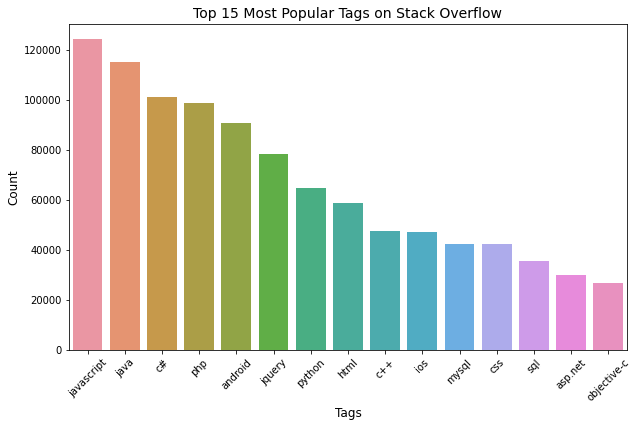

In [16]:
plt.figure(figsize=(10, 6))  # Set figure size
sns.barplot(x=top_tags.index, y=top_tags.values)
plt.xticks(rotation=45)
plt.title('Top 15 Most Popular Tags on Stack Overflow', fontsize=14)
plt.xlabel('Tags', fontsize=12)
plt.ylabel('Count', fontsize=12)


# save the plot with a name and high quality
plt.savefig('/content/drive/MyDrive/thesis/img/top_15_tags.png', dpi=300)

plt.show()

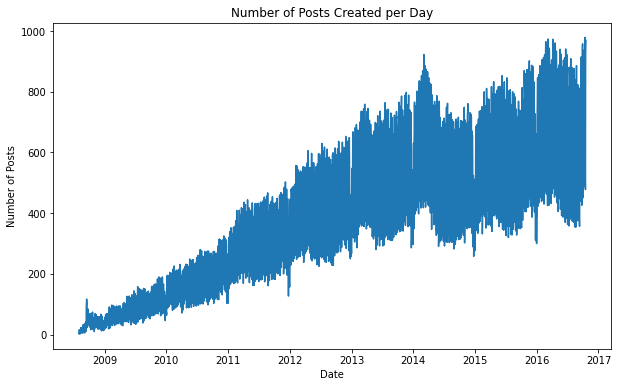

In [17]:
# Visualize the distribution of post creation dates using a line chart
questions["CreationDate"] = pd.to_datetime(questions["CreationDate"])
df = questions.set_index("CreationDate")
plt.figure(figsize=(10, 6))
posts_per_day = df.resample("D").count()["Id"]
plt.plot(posts_per_day)
plt.title("Number of Posts Created per Day")
plt.xlabel("Date")
plt.ylabel("Number of Posts")

plt.savefig('/content/drive/MyDrive/thesis/img/posts_per_day.png', dpi=300)
plt.show()

In [18]:
def plot_tags(tagCount):
    
    x,y = zip(*tagCount)

    colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired  
    colors = [colormap(i) for i in np.linspace(0, 0.8,50)]   

    area = [i/4000 for i in list(y)]   # 0 to 15 point radiuses
    plt.figure(figsize=(10, 6))
    plt.ylabel("Number of question associations")
    plt.title("Top 15 Tag Counts")
    plt.xlabel("Tags")
    for i in range(len(y)):
        plt.plot(i,y[i], marker='o', linestyle='',ms=area[i],label=x[i])

    plt.legend(numpoints=1)
    plt.savefig('/content/drive/MyDrive/thesis/img/top_15_tags_colormap.png', dpi=300)
    plt.show()

[('javascript', 124155), ('java', 115212), ('c#', 101186), ('php', 98808), ('android', 90659), ('jquery', 78542), ('python', 64601), ('html', 58976), ('c++', 47591), ('ios', 47009), ('mysql', 42464), ('css', 42308), ('sql', 35782), ('asp.net', 29970), ('objective-c', 26922)]


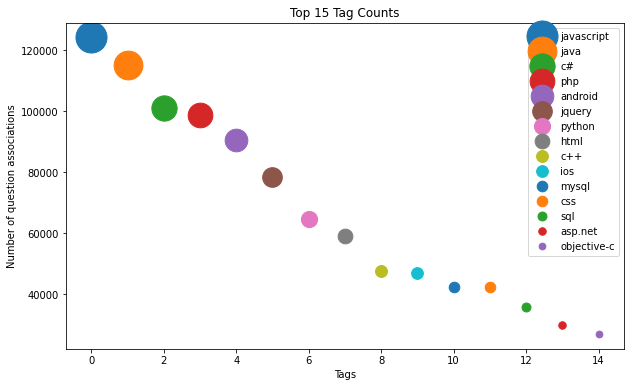

In [19]:
import collections
tagCount =  collections.Counter(list(tags['Tag'])).most_common(15)
print(tagCount)
plot_tags(tagCount)

In [20]:
tags['Tag'] = tags['Tag'].astype(str)

In [21]:
grouped_tags = tags.groupby("Id")['Tag'].apply(lambda tags: ' '.join(tags))

In [22]:
grouped_tags.head(5)

Id
80                            flex actionscript-3 air
90       svn tortoisesvn branch branching-and-merging
120                               sql asp.net sitemap
180    algorithm language-agnostic colors color-space
260           c# .net scripting compiler-construction
Name: Tag, dtype: object

In [23]:
grouped_tags.reset_index()

,Id,Tag
0,80,flex actionscript-3 air
1,90,svn tortoisesvn branch branching-and-merging
2,120,sql asp.net sitemap
3,180,algorithm language-agnostic colors color-space
4,260,c# .net scripting compiler-construction
...,...,...
1264211,40143210,php .htaccess
1264212,40143300,google-bigquery
1264213,40143340,android android-studio
1264214,40143360,javascript vue.js


In [24]:
grouped_tags_final = pd.DataFrame({'Id':grouped_tags.index, 'Tags':grouped_tags.values})

In [25]:
grouped_tags_final.head(5)

,Id,Tags
0,80,flex actionscript-3 air
1,90,svn tortoisesvn branch branching-and-merging
2,120,sql asp.net sitemap
3,180,algorithm language-agnostic colors color-space
4,260,c# .net scripting compiler-construction


In [26]:
questions.drop(columns=['OwnerUserId', 'CreationDate', 'ClosedDate'], inplace=True)

In [27]:
questions = questions.merge(grouped_tags_final, on='Id')

In [28]:
questions.head(5)

,Id,Score,Title,Body,Tags
0,80,26,SQLStatement.execute() - multiple queries in one statement,"<p>I've written a database generation script in <a href=""http://en.wikipedia.org/wiki/SQL"">SQL</a> and want to execute it in my <a href=""http://en.wikipedia.org/wiki/Adobe_Integrated_Runtime"">Adob...",flex actionscript-3 air
1,90,144,Good branching and merging tutorials for TortoiseSVN?,"<p>Are there any really good tutorials explaining <a href=""http://svnbook.red-bean.com/en/1.8/svn.branchmerge.html"" rel=""nofollow"">branching and merging</a> with Apache Subversion? </p>\n\n<p>All ...",svn tortoisesvn branch branching-and-merging
2,120,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>SQL-based ASP.NET</strong> site-map providers?</p>\n\n<p>I've got the default XML file <code>web.sitemap</code> working properly with my Menu and <str...,sql asp.net sitemap
3,180,53,Function for creating color wheels,"<p>This is something I've pseudo-solved many times and never quite found a solution. That's stuck with me. The problem is to come up with a way to generate <code>N</code> colors, that are as disti...",algorithm language-agnostic colors color-space
4,260,49,Adding scripting functionality to .NET applications,"<p>I have a little game written in C#. It uses a database as back-end. It's \na <a href=""http://en.wikipedia.org/wiki/Collectible_card_game"">trading card game</a>, and I wanted to implement the fu...",c# .net scripting compiler-construction


Finding top categories and sub categories which are mostly asked by the users

In [29]:
df_tags = questions[["Tags"]]
df_tags = pd.concat([df_tags[['Tags']], df_tags['Tags'].str.split(' ', expand = True)], axis = 1)
df_tags = df_tags.drop('Tags', axis = 1)
df_tags.head()

,0,1,2,3,4
0,flex,actionscript-3,air,None,None
1,svn,tortoisesvn,branch,branching-and-merging,None
2,sql,asp.net,sitemap,None,None
3,algorithm,language-agnostic,colors,color-space,None
4,c#,.net,scripting,compiler-construction,None


In [30]:
def tag_count(x):
    x = len(x.split())
    return x

count = lambda x:tag_count(x)

data = pd.DataFrame()
data['TagCount'] = pd.DataFrame(questions.Tags.apply(count))
print("The tag count is calculated...")

The tag count is calculated...


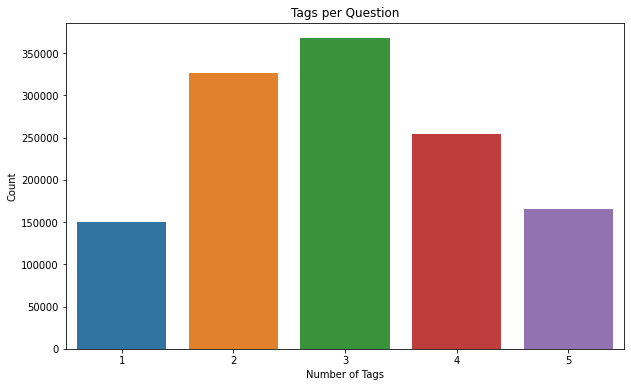

In [31]:
plt.figure(figsize=(10, 6))
sns.countplot(data['TagCount'])
plt.title('Tags per Question')
plt.xlabel('Number of Tags')
plt.ylabel('Count')
plt.savefig('/content/drive/MyDrive/thesis/img/tag_count.png', dpi=300)
plt.show()

Now, I'll take only quesions witha score greater than 5. I'm doing that for 2 reasons:
* 1- I'll require less computational resources from kaggle.
* 2- The posts will probably be with a better quality and will be better tagged since they have lots of upvotes. 


In [32]:
new_df = questions[questions['Score']>5]

**1.2 Cleaning Data**

In [33]:
# check for null values
print("\nInitial number of null values: ", new_df.isnull().sum().sum())

# check for duplicates
print("\nInitial number of duplicates: ", new_df.duplicated().sum())


Initial number of null values:  0

Initial number of duplicates:  0


This is a very good dataset since there are no missing valeus or dupplicate values. 

In [34]:
new_df.drop(columns=['Id', 'Score'], inplace=True)

Now we only need 3 columns: Body, Title and Tags. 

**1.2.1 Tags**

Let's do some cleaning on the tags' column. Furthermore, I decided to keep the 100 most popular tags because I'll be easier to predict the right tag from 100 words than from 14,000 and because we want to keep macro tags and not be too specific since it's only a recommendation for a post, the user can add more specific tags himself. 

In [35]:
new_df.head(5)

,Title,Body,Tags
0,SQLStatement.execute() - multiple queries in one statement,"<p>I've written a database generation script in <a href=""http://en.wikipedia.org/wiki/SQL"">SQL</a> and want to execute it in my <a href=""http://en.wikipedia.org/wiki/Adobe_Integrated_Runtime"">Adob...",flex actionscript-3 air
1,Good branching and merging tutorials for TortoiseSVN?,"<p>Are there any really good tutorials explaining <a href=""http://svnbook.red-bean.com/en/1.8/svn.branchmerge.html"" rel=""nofollow"">branching and merging</a> with Apache Subversion? </p>\n\n<p>All ...",svn tortoisesvn branch branching-and-merging
2,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>SQL-based ASP.NET</strong> site-map providers?</p>\n\n<p>I've got the default XML file <code>web.sitemap</code> working properly with my Menu and <str...,sql asp.net sitemap
3,Function for creating color wheels,"<p>This is something I've pseudo-solved many times and never quite found a solution. That's stuck with me. The problem is to come up with a way to generate <code>N</code> colors, that are as disti...",algorithm language-agnostic colors color-space
4,Adding scripting functionality to .NET applications,"<p>I have a little game written in C#. It uses a database as back-end. It's \na <a href=""http://en.wikipedia.org/wiki/Collectible_card_game"">trading card game</a>, and I wanted to implement the fu...",c# .net scripting compiler-construction


In [36]:
new_df['Tags'] = new_df['Tags'].apply(lambda x: x.split())

In [37]:
all_tags = [item for sublist in new_df['Tags'].values for item in sublist]

In [38]:
len(all_tags)

224129

In [39]:
new_df.head(5)

,Title,Body,Tags
0,SQLStatement.execute() - multiple queries in one statement,"<p>I've written a database generation script in <a href=""http://en.wikipedia.org/wiki/SQL"">SQL</a> and want to execute it in my <a href=""http://en.wikipedia.org/wiki/Adobe_Integrated_Runtime"">Adob...","[flex, actionscript-3, air]"
1,Good branching and merging tutorials for TortoiseSVN?,"<p>Are there any really good tutorials explaining <a href=""http://svnbook.red-bean.com/en/1.8/svn.branchmerge.html"" rel=""nofollow"">branching and merging</a> with Apache Subversion? </p>\n\n<p>All ...","[svn, tortoisesvn, branch, branching-and-merging]"
2,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>SQL-based ASP.NET</strong> site-map providers?</p>\n\n<p>I've got the default XML file <code>web.sitemap</code> working properly with my Menu and <str...,"[sql, asp.net, sitemap]"
3,Function for creating color wheels,"<p>This is something I've pseudo-solved many times and never quite found a solution. That's stuck with me. The problem is to come up with a way to generate <code>N</code> colors, that are as disti...","[algorithm, language-agnostic, colors, color-space]"
4,Adding scripting functionality to .NET applications,"<p>I have a little game written in C#. It uses a database as back-end. It's \na <a href=""http://en.wikipedia.org/wiki/Collectible_card_game"">trading card game</a>, and I wanted to implement the fu...","[c#, .net, scripting, compiler-construction]"


In [40]:
my_set = set(all_tags)
unique_tags = list(my_set)
len(unique_tags)

14883

In [41]:
flat_list = [item for sublist in new_df['Tags'].values for item in sublist]

keywords = nltk.FreqDist(flat_list)

frequencies_words = keywords.most_common(15)
tags_features = [word[0] for word in frequencies_words]

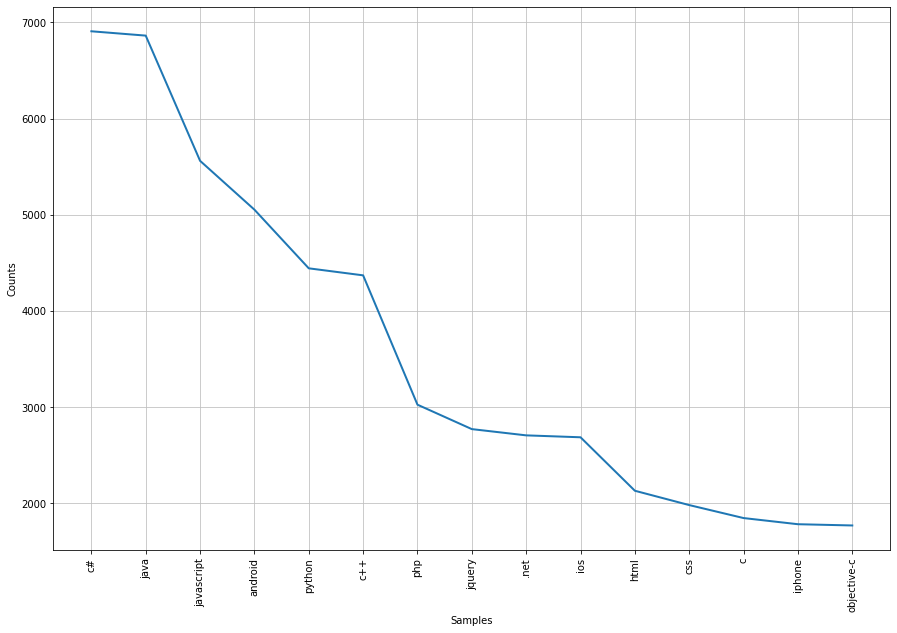

In [42]:
fig, ax = plt.subplots(figsize=(15, 10))
keywords.plot(15, cumulative=False)
plt.show()

In [43]:
def most_common(tags):
    tags_filtered = []
    for i in range(0, len(tags)):
        if tags[i] in tags_features:
            tags_filtered.append(tags[i])
    return tags_filtered

In [44]:
new_df['Tags'] = new_df['Tags'].apply(lambda x: most_common(x))
new_df['Tags'] = new_df['Tags'].apply(lambda x: x if len(x)>0 else None)

In [45]:
new_df.shape

(72950, 3)

In [46]:
new_df.dropna(subset=['Tags'], inplace=True)

In [47]:
new_df.shape

(44501, 3)

In [48]:
new_df.head(5)

,Title,Body,Tags
4,Adding scripting functionality to .NET applications,"<p>I have a little game written in C#. It uses a database as back-end. It's \na <a href=""http://en.wikipedia.org/wiki/Collectible_card_game"">trading card game</a>, and I wanted to implement the fu...","[c#, .net]"
5,Should I use nested classes in this case?,"<p>I am working on a collection of classes used for video playback and recording. I have one main class which acts like the public interface, with methods like <code>play()</code>, <code>stop()</c...",[c++]
6,Homegrown consumption of web services,"<p>I've been writing a few web services for a .net app, now I'm ready to consume them. I've seen numerous examples where there is homegrown code for consuming the service as opposed to using the a...",[.net]
8,Automatically update version number,<p>I would like the version property of my application to be incremented for each build but I'm not sure on how to enable this functionality in Visual Studio (2005/2008). I have tried to specify t...,[c#]
10,How do I connect to a database and loop over a recordset in C#?,<p>What's the simplest way to connect and query a database for a set of records in C#?</p>\n,[c#]


In [49]:
new_df["no_of_tags"] = new_df["Tags"].apply(len)

In [50]:
new_df.head(5)

,Title,Body,Tags,no_of_tags
4,Adding scripting functionality to .NET applications,"<p>I have a little game written in C#. It uses a database as back-end. It's \na <a href=""http://en.wikipedia.org/wiki/Collectible_card_game"">trading card game</a>, and I wanted to implement the fu...","[c#, .net]",2
5,Should I use nested classes in this case?,"<p>I am working on a collection of classes used for video playback and recording. I have one main class which acts like the public interface, with methods like <code>play()</code>, <code>stop()</c...",[c++],1
6,Homegrown consumption of web services,"<p>I've been writing a few web services for a .net app, now I'm ready to consume them. I've seen numerous examples where there is homegrown code for consuming the service as opposed to using the a...",[.net],1
8,Automatically update version number,<p>I would like the version property of my application to be incremented for each build but I'm not sure on how to enable this functionality in Visual Studio (2005/2008). I have tried to specify t...,[c#],1
10,How do I connect to a database and loop over a recordset in C#?,<p>What's the simplest way to connect and query a database for a set of records in C#?</p>\n,[c#],1


In [51]:
min_tag_count = new_df["no_of_tags"].min()
max_tag_count = new_df["no_of_tags"].max()
avg_tag_count = new_df["no_of_tags"].mean()

In [52]:
print(f"Each question has a minimum of {min_tag_count} tag and a maximum of {max_tag_count} tags. \
The average number of tags per question is {avg_tag_count:.2f}.")

Each question has a minimum of 1 tag and a maximum of 5 tags. The average number of tags per question is 1.21.


In [53]:
with open('/content/drive/MyDrive/thesis/cleaned_dataframe.pkl', 'wb') as f:
    pickle.dump((new_df,tags_features), f)

Most popular technologies


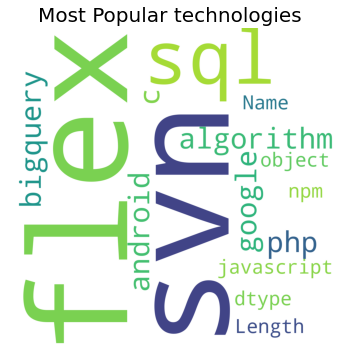

In [55]:
from wordcloud import WordCloud

plt.rcParams['figure.figsize'] = (18, 6)
wordcloud = WordCloud(background_color = 'white', width = 1200,  height = 1200, max_words = 121).generate(str(df_tags[0]))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Most Popular technologies',fontsize = 20)
plt.savefig('/content/drive/MyDrive/thesis/img/popular_wordcloud.png', dpi=300)
plt.show()

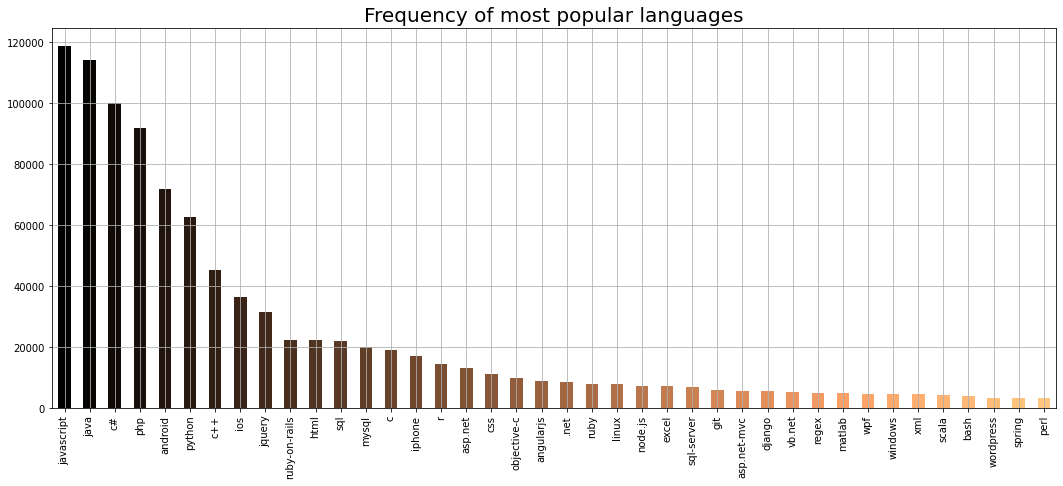

In [56]:
# looking at the frequency of most popular items 

plt.rcParams['figure.figsize'] = (18, 7)
color = plt.cm.copper(np.linspace(0, 1, 40))
df_tags[0].value_counts().head(40).plot.bar(color = color)
plt.title('Frequency of most popular languages', fontsize = 20)
plt.xticks(rotation = 90 )
plt.grid()
plt.savefig('/content/drive/MyDrive/thesis/img/most_popular_languages.png', dpi=300)
plt.show()

In [57]:
y = df_tags[0].value_counts().head(50).to_frame()
y.index

Index(['javascript', 'java', 'c#', 'php', 'android', 'python', 'c++', 'ios',
       'jquery', 'ruby-on-rails', 'html', 'sql', 'mysql', 'c', 'iphone', 'r',
       'asp.net', 'css', 'objective-c', 'angularjs', '.net', 'ruby', 'linux',
       'node.js', 'excel', 'sql-server', 'git', 'asp.net-mvc', 'django',
       'vb.net', 'regex', 'matlab', 'wpf', 'windows', 'xml', 'scala', 'bash',
       'wordpress', 'spring', 'perl', 'algorithm', 'json', 'swift', 'facebook',
       'eclipse', 'arrays', 'database', 'osx', 'delphi', 'apache'],
      dtype='object')

In [59]:
!pip install squarify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


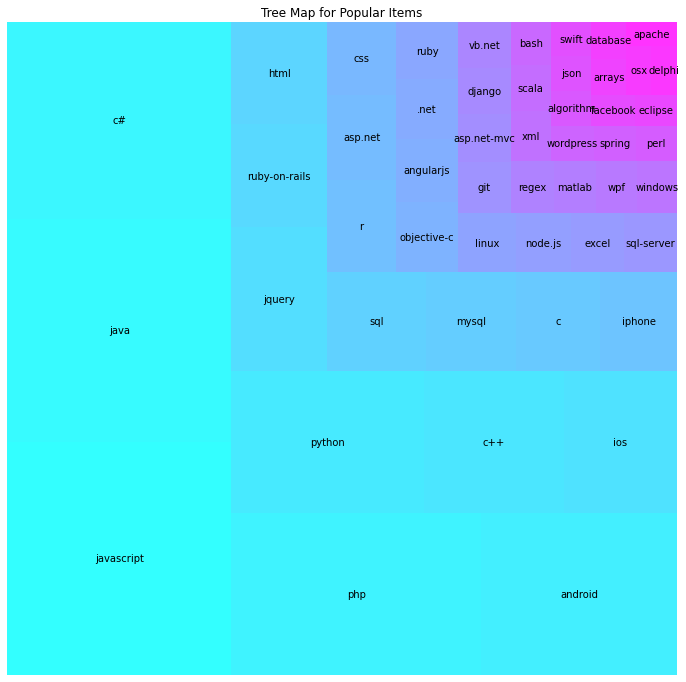

In [62]:
# plotting a tree map
import squarify

plt.rcParams['figure.figsize'] = (12, 12)
color = plt.cm.cool(np.linspace(0, 1, 50))
squarify.plot(sizes = y.values, label = y.index, alpha = .8, color = color)
plt.title('Tree Map for Popular Items')
plt.axis('off')
plt.savefig('/content/drive/MyDrive/thesis/img/tree_map.png', dpi=300)
plt.show()

Top 15 technologies with most asked questions and top 15 sub categories' plots

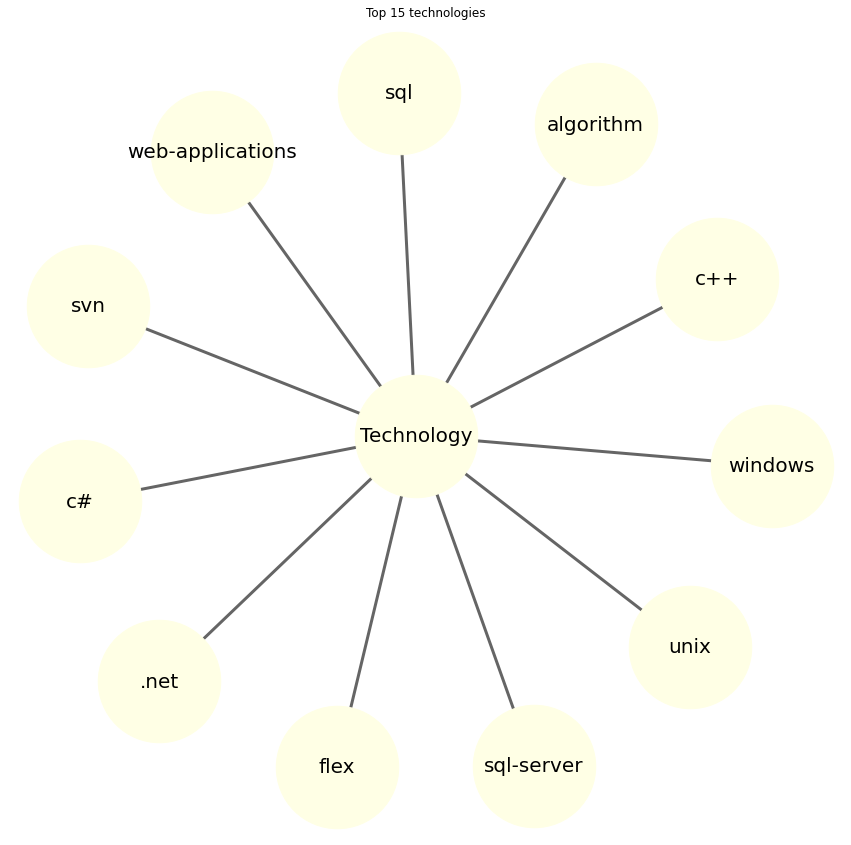

In [72]:
import networkx as nx

df_tags['technology'] = 'Technology'
technology = df_tags.truncate(before = -1, after = 15)

technology = nx.from_pandas_edgelist(technology, source = 'technology', target = 0, edge_attr = True)

plt.rcParams['figure.figsize'] = (15, 15)
pos = nx.spring_layout(technology)
color = plt.cm.YlOrBr(np.linspace(0, 15, 1))
nx.draw_networkx_nodes(technology, pos, node_size = 15000, node_color = color)
nx.draw_networkx_edges(technology, pos, width = 3, alpha = 0.6, edge_color = 'black')
nx.draw_networkx_labels(technology, pos, font_size = 20, font_family = 'sans-serif')
plt.axis('off')
plt.grid()
plt.title('Top 15 technologies', fontsize = 12)
plt.savefig('/content/drive/MyDrive/thesis/img/top15_technologies.png', dpi=300)
plt.show()

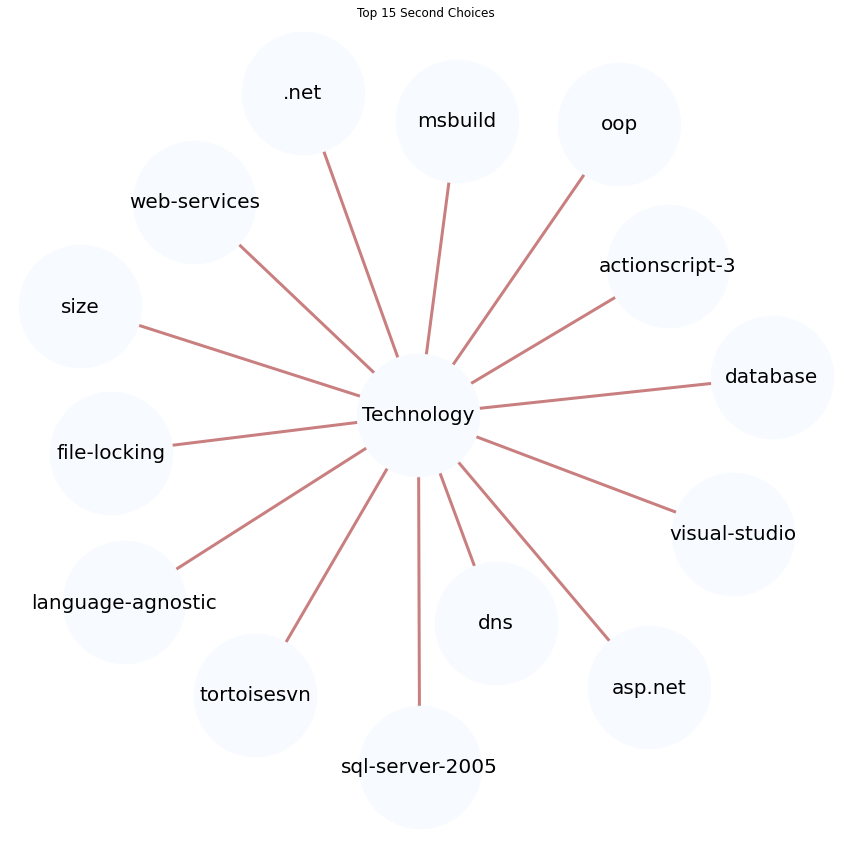

In [71]:
df_tags['secondchoice'] = 'Second Choice'
secondchoice = df_tags.truncate(before = -1, after = 15)
secondchoice = nx.from_pandas_edgelist(secondchoice, source = 'technology', target = 1, edge_attr = True)

plt.rcParams['figure.figsize'] = (15, 15)
pos = nx.spring_layout(secondchoice)
color = plt.cm.Blues(np.linspace(0, 15, 1))
nx.draw_networkx_nodes(secondchoice, pos, node_size = 15000, node_color = color)
nx.draw_networkx_edges(secondchoice, pos, width = 3, alpha = 0.6, edge_color = 'brown')
nx.draw_networkx_labels(secondchoice, pos, font_size = 20, font_family = 'sans-serif')
plt.axis('off')
plt.grid()
plt.title('Top 15 Second Choices', fontsize = 12)
plt.savefig('/content/drive/MyDrive/thesis/img/top15_second_choice.png', dpi=300)
plt.show()